In [87]:
%load_ext rpy2.ipython

from rpy2.robjects.packages import importr
import numpy as np
import pandas as pd
from chromax import Simulator
import tensorflow as tf
import numpy as np
from tqdm import tqdm

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [88]:

def plot_means_and_variances(dataframes):
    # Calculate the mean and variance for each dataframe
    mean_values = [df.mean() for df in dataframes]
    var_values = [df.var() for df in dataframes]
    var_values = np.array(var_values).flatten()
    mean_values = np.array(mean_values).flatten()

    # Create an array for the x-values
    x_values = range(len(dataframes))

    # Create the scatter plot with error bars
    plt.errorbar(x_values, mean_values, yerr=var_values, fmt='o')

    # Display the plot
    plt.show()


def generate_genetic_map(n_markers, n_chromosomes):
  df = pd.DataFrame(generate_marker_effects(n_markers=n_markers), columns=['Yield'])
  df['cM'] = np.random.uniform(0, 200, len(df))
  df['CHR.PHYS'] = '1A'
  df = df.sort_values(by='cM')
  df = df[['CHR.PHYS', 'cM', 'Yield']]
  # save df as csv under filename
  return df

def generate_population(n_pop=100, n_markers=500):
    """
    Generate a numpy array of randoms of length 500 with randomized 0, 1, or 2 at each position.
    It will generate 100 individuals based on n_pop.

    Returns: numpy array of size (n_pop, n_markers)
    """
    shape=(n_pop, n_markers, 2)
    # Define the elements to choose from and their associated probabilities
    elements = [0, 1, 2]
    probabilities = [1/3, 1/3, 1/3]  # equal probabilities for 0, 1, and 2

    # Generate the population
    population = np.random.choice(elements, size=(n_pop, n_markers), p=probabilities)

    return np.random.choice([True, False], size=shape)


def generate_marker_effects(n_markers=500, mu=0, sigma=0.1):
    """
    Generate a numpy array of marker effects with a normal distribution.

    Parameters:
    n_markers (int): Number of markers.
    mu (float): Mean of the distribution.
    sigma (float): Standard deviation of the distribution.

    Returns:
    numpy array of marker effects
    """

    # Generate the marker effects
    marker_effects = np.random.normal(mu, sigma, n_markers)

    return marker_effects


def select_random_individuals(arr, num_individuals):
    # Get the shape of the array
    shape = arr.shape

    # Generate random indices along the first axis
    idx = np.random.choice(shape[0], size=num_individuals)

    # Select the random individuals

    return random_individuals

def select_mixed(population, random_split=.99):
  n_pop = population.shape[0]

  n_random = int(n_pop * random_split)
  n_select = int(n_pop * (1-random_split))

  random_parents = select_random_individuals(Farm.current_population, n_random)
  selected_parents = Farm.Simulator.select(Farm.current_population, k = n_select)
  combined_arr = np.concatenate((random_parents, selected_parents), axis=0)
  return combined_arr

def plot_replicate_means_and_variances(replicate_data, start_index=None, end_index=None):
    # Create a new figure and axes
    fig, ax = plt.subplots()

    # If start_index or end_index is not provided, set them to default values
    if start_index is None:
        start_index = 0
    if end_index is None:
        end_index = len(replicate_data[0])

    # For each list of dataframes in replicate_data
    for i, dataframes in enumerate(replicate_data):
        # Select the dataframes in the specified range
        dataframes = dataframes[start_index:end_index]

        # Calculate the mean and variance for each dataframe
        mean_values = [df.mean() for df in dataframes]
        var_values = [df.var() for df in dataframes]

        # Flatten the var_values and mean_values lists to 1D arrays
        var_values = np.array(var_values).flatten()
        mean_values = np.array(mean_values).flatten()

        # Create an array for the x-values
        x_values = range(len(dataframes))

        # Plot the means with error bars for the variances
        ax.errorbar(x_values, mean_values, yerr=var_values, fmt='o', label=f'Replicate {i+1}')

    # Add a legend
    ax.legend()

    # Display the plot
    plt.show()


def plot_replicate_means(replicate_data):
    # Create a new figure and axes
    fig, ax = plt.subplots()

    # For each list of dataframes in replicate_data
    for i, dataframes in enumerate(replicate_data):
        # Calculate the mean for each dataframe
        mean_values = [df.mean() for df in dataframes]
        # Flatten the mean_values list to a 1D array
        mean_values = np.array(mean_values).flatten()

        # Create an array for the x-values
        x_values = range(len(dataframes))

        # Plot the means as a line plot
        ax.plot(x_values, mean_values, label=f'Replicate {i+1}')

    # Add a legend
    ax.legend()

    # Display the plot
    plt.show()

def parse_markerEffects(genetic_map, nChr):
    # Get the length of the genetic map
    length = len(genetic_map)

    # Create a new array for storing the chromosome number for each marker
    chr = [0] * length

    # Calculate the number of markers per chromosome
    markers_per_chr = length // nChr

    # Iterate over the range of the genetic map length
    for i in range(length):
        # Calculate the chromosome number and store it in the chr array
        chr[i] = i // markers_per_chr + 1

    return chr

def score_top(scores: pd.DataFrame, column: str, k: int):
    # Sort the DataFrame from high to low
    sorted_scores = scores.sort_values(by=column, ascending=False)
    # Get the top K indexes
    top_k_indexes = sorted_scores.head(k).index
    return top_k_indexes


def score_top_percentile(scores: pd.DataFrame, column: str, percentile_min: float, percentile_max: float, k: int):
    # Ensure max percentile is greater than min percentile
    assert percentile_max > percentile_min, "Error: max percentile should be greater than min percentile"
    
    # Calculate the percentiles
    lower = scores[column].quantile(percentile_min)
    upper = scores[column].quantile(percentile_max)
    # Filter the DataFrame
    filtered_scores = scores[(scores[column] >= lower) & (scores[column] <= upper)]
    # Sample k random indexes
    sampled_indexes = np.random.choice(filtered_scores.index, k, replace=True)

    return sampled_indexes

def reshape_pop(maizeHaplo):
    reshapeHaplo = maizeHaplo.reshape(int((maizeHaplo.shape[0])/2),2,maizeHaplo.shape[1])
    reshapeHaplo = reshapeHaplo.transpose((0,2,1))
    return reshapeHaplo

def return_genetic_map_df(markerEffects, nChr, geneticMap):
    chr = parse_markerEffects(markerEffects, nChr)
    chr = [int(x[0]) for x in chr]
    trait = markerEffects
    pos = geneticMap
    # Assuming chr, trait, pos are your arrays
    df = pd.DataFrame({'CHR.PHYS': chr, 'Yield': trait, 'cM': pos})
    return df

import matplotlib.pyplot as plt

def plot_histogram(ax, probabilities, label=None, color=None):
    ax.hist(probabilities, bins='auto', density=True, alpha=0.5, label=label, color=color)
    ax.set_title('Probability Distribution')
    ax.set_xlabel('Probability')
    ax.set_ylabel('Frequency')

def plot_bar(ax, probabilities, label=None, color=None):
    indices = range(len(probabilities))
    ax.bar(indices, probabilities, alpha=0.5, label=label, color=color)
    ax.set_title('Probability per Index')
    ax.set_xlabel('Index')
    ax.set_ylabel('Probability')

def plot_probabilities(probabilities1, probabilities2):
    # Create subplots: 1 row, 2 columns
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    # Call the plot functions for the first set of probabilities
    plot_histogram(axs[0], probabilities1, label='Probabilities 1', color='blue')
    plot_bar(axs[1], probabilities1, label='Probabilities 1', color='blue')

    # Call the plot functions for the second set of probabilities
    plot_histogram(axs[0], probabilities2, label='Probabilities 2', color='red')
    plot_bar(axs[1], probabilities2, label='Probabilities 2', color='red')

    # Add legends
    axs[0].legend(loc='upper right')
    axs[1].legend(loc='upper right')

    # Display the plots
    plt.tight_layout()  # Adjusts subplot params so that subplots fit in the figure area
    plt.show()

def select_parent(probabilities):
    try:
        # Ensure probabilities sum up to 1
        probabilities = np.array(probabilities, dtype=np.float64)
        probabilities[-1] = max(0, 1 - np.sum(probabilities[:-1]))
        indices = np.arange(len(probabilities))  # Create an array of indices
        sampled_index = np.random.choice(indices, p=probabilities)  # Sample an index based on the probabilities
    except ValueError:
        print("Error: probabilities do not sum up to 1")
        print("Probabilities:", probabilities)
        raise
    return sampled_index



In [89]:
%%R
x <- seq(0, 2*pi, length.out=50)

In [90]:
%R -o x

In [91]:
x

array([0.        , 0.12822827, 0.25645654, 0.38468481, 0.51291309,
       0.64114136, 0.76936963, 0.8975979 , 1.02582617, 1.15405444,
       1.28228272, 1.41051099, 1.53873926, 1.66696753, 1.7951958 ,
       1.92342407, 2.05165235, 2.17988062, 2.30810889, 2.43633716,
       2.56456543, 2.6927937 , 2.82102197, 2.94925025, 3.07747852,
       3.20570679, 3.33393506, 3.46216333, 3.5903916 , 3.71861988,
       3.84684815, 3.97507642, 4.10330469, 4.23153296, 4.35976123,
       4.48798951, 4.61621778, 4.74444605, 4.87267432, 5.00090259,
       5.12913086, 5.25735913, 5.38558741, 5.51381568, 5.64204395,
       5.77027222, 5.89850049, 6.02672876, 6.15495704, 6.28318531])

In [92]:
# %R install.packages("AlphaSimR")

In [93]:
%%R
library("AlphaSimR")

In [94]:
%%R
nInd = 50
nChr = 3
segSites = 10

founderGenomes = runMacs(nInd = nInd,
                         nChr = nChr,
                         segSites = segSites,
                         species = "MAIZE")


In [95]:
%%R
SP = SimParam$new(founderGenomes)
SP$addTraitA(segSites)
# SP$setVarE(h2=.02)
pop = newPop(founderGenomes, simParam=SP)
ans = fastRRBLUP(pop, simParam=SP, useQtl=TRUE, use='gv')
ans@gv[[1]]@addEff
markerEffects = slot(slot(ans, "gv")[[1]], "addEff")
maizeHaplo = pullSegSiteHaplo(pop)
maizeGeno = pullSegSiteGeno(pop)
#cm positions of each marker
genMap = SP$genMap
geneticMap = unlist(genMap)

In [96]:
%R -o maizeHaplo
%R -o maizeGeno
%R -o markerEffects
%R -o geneticMap
%R -o nInd
%R -o nChr
%R -o segSites

In [309]:
from tensorflow import keras
from tensorflow.keras.layers import Dense, Input, Flatten, Reshape

#create init population + genetic map
n = int(nInd)
m = int((segSites * nChr))
d = 2
total_parents = 100 # pop size per cycle

def calculate_actor_loss(actor_output, selected_array):
    #calculate actor loss
    actor_log_probs = tf.math.log(actor_output)  #log probabilities of the actions given by the actor
    selected_log_probs = tf.gather(actor_log_probs, selected_array, axis=1)  #log probabilities of the selected actions
    loss = -tf.reduce_sum(selected_log_probs)  #negative sum of the log probabilities of the selected actions
    return loss

def calculate_true_reward(simulator, current_population, new_population):
    true_reward = simulator.GEBV(new_population).mean() - simulator.GEBV(current_population).mean()
    return true_reward


def create_actor():
    # Define the actor model
    actor_input = keras.layers.Input(shape=(n, m, d))
    x = Flatten()(actor_input)
    x = Dense(64, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    x = Dense(n * total_parents, activation='linear')(x)
    x = Reshape((total_parents, n))(x)
    actor_output = keras.layers.Softmax(axis=-1)(x)
    actor_model = keras.models.Model(actor_input, actor_output)
    actor_model.compile(optimizer='adam', loss='categorical_crossentropy')
    return actor_model

def create_critic():
    # Define the critic model
    critic_input1 = keras.layers.Input(shape=(n, m, d))
    critic_input2 = keras.layers.Input(shape=(total_parents, n))

    x1 = Flatten()(critic_input1)
    x1 = Dense(256, activation='relu')(x1)

    x2 = Flatten()(critic_input2)
    x2 = Dense(256, activation='relu')(x2)

    combined = keras.layers.concatenate([x1, x2])

    x3 = Dense(256, activation='relu')(combined)
    critic_output = Dense(1, activation='linear')(x3)

    critic_model = keras.models.Model([critic_input1, critic_input2], critic_output)
    critic_model.compile(optimizer='adam', loss='mse')
    return critic_model

In [317]:
from tensorflow import keras
from tensorflow.keras.layers import Dense, Input, Flatten, Reshape

#create init population + genetic map
n = int(nInd)
m = int((segSites * nChr))
d = 2
total_parents = 100 # pop size per cycle

def calculate_actor_loss(actor_output, selected_array):
    #calculate actor loss
    actor_log_probs = tf.math.log(actor_output)  #log probabilities of the actions given by the actor
    selected_log_probs = tf.gather(actor_log_probs, selected_array, axis=1)  #log probabilities of the selected actions
    loss = -tf.reduce_sum(selected_log_probs)  #negative sum of the log probabilities of the selected actions
    return loss

def calculate_true_reward(simulator, current_population, new_population):
    true_reward = simulator.GEBV(new_population).mean() - simulator.GEBV(current_population).mean()
    return true_reward


def create_actor():
    # Define the actor model
    actor_input = keras.layers.Input(shape=(n, m, d))
    x = Flatten()(actor_input)
    x = Dense(64, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    x = Dense(n * total_parents, activation='linear')(x)
    x = Reshape((total_parents, n))(x)
    actor_output = keras.layers.Softmax(axis=-1)(x)
    actor_model = keras.models.Model(actor_input, actor_output)
    actor_model.compile(optimizer='adam', loss='categorical_crossentropy')
    return actor_model

def create_critic():
    # Define the critic model
    critic_input1 = keras.layers.Input(shape=(n, m, d))
    critic_input2 = keras.layers.Input(shape=(total_parents, n))

    x1 = Flatten()(critic_input1)
    x1 = Dense(256, activation='relu')(x1)

    x2 = Flatten()(critic_input2)
    x2 = Dense(256, activation='relu')(x2)

    combined = keras.layers.concatenate([x1, x2])

    x3 = Dense(256, activation='relu')(combined)
    critic_output = Dense(1, activation='linear')(x3)

    critic_model = keras.models.Model([critic_input1, critic_input2], critic_output)
    critic_model.compile(optimizer='adam', loss='mse')
    return critic_model

actor_model = create_actor()
critic_model = create_critic()
# Create a dummy population
example_population = np.random.randint(0, 2, (n, m, d))
example_population = np.expand_dims(example_population, axis=0)

# Send the example through the actor network
actor_output = actor_model.predict(example_population)
print(f'actor model output : {actor_output.shape}')
print(f'example population shape, single sample : {example_population.shape}')

# Predict
critic_output = critic_model.predict([ example_population, actor_output])

# Print the output
print(f'critic model output: {critic_output.shape}')
print(critic_output[0][0:5])

print(f"""
      population size  : {nInd}
      number of markers  : {m }
      diploidy : {d}
      """)

action_selections = [select_parent(x) for x in actor_output[0,:,:]]

# Reshape action selections into pairs of parents
# This prepares the selected parents for the breeding simulation
selected_array = np.array([action_selections[i:i+2] for i in range(0, len(action_selections), 2)])
#cross
new_population = farm.simulator.cross(example_population[0][selected_array])
#calculate actor loss
actor_loss = calculate_actor_loss(actor_output[0], selected_array)
true_reward = calculate_critic_loss(farm.simulator,farm.current_population, new_population)[0]
critic_loss = (critic_output[0][0] - true_reward)**2


# First, create optimizers for your actor and critic models
actor_optimizer = tf.keras.optimizers.Adam()
critic_optimizer = tf.keras.optimizers.Adam()

# Then, use GradientTape to calculate and apply gradients
with tf.GradientTape() as actor_tape, tf.GradientTape() as critic_tape:
    # Assume you've calculated actor_loss and critic_loss here
    actor_loss = calculate_actor_loss(actor_output[0], selected_array)
    true_reward = calculate_true_reward(farm.simulator, farm.current_population, new_population)
    critic_loss = (critic_output[0][0] - true_reward)**2

    # Get the gradients
    actor_grads = actor_tape.gradient(actor_loss, actor_model.trainable_variables)
    critic_grads = critic_tape.gradient(critic_loss, critic_model.trainable_variables)

    # Apply the gradients
    actor_optimizer.apply_gradients(zip(actor_grads, actor_model.trainable_variables))
    critic_optimizer.apply_gradients(zip(critic_grads, critic_model.trainable_variables))



1/1 [==============================] - 0s 63ms/step
actor model output : (1, 100, 50)
example population shape, single sample : (1, 50, 30, 2)
1/1 [==============================] - 0s 53ms/step
critic model output: (1, 1)
[0.5095636]

      population size  : [50.]
      number of markers  : 30
      diploidy : 2
      


AttributeError: 'Series' object has no attribute '_id'

0.2455176788859923

In [284]:
critic_output

array([[-0.48680174]], dtype=float32)

Yield    0.000661
dtype: float32


In [ ]:
# Assuming critic_output is the output of your critic network
# and returns is the actual return calculated from your simulation
critic_loss = tf.reduce_mean(tf.square(returns - critic_output))


actos loss 39179.2890625


In [268]:
action_probabilities

<tf.Tensor: shape=(100, 50, 2), dtype=float32, numpy=
array([[[0.01960192, 0.01945123],
        [0.02205056, 0.01948449],
        [0.01983046, 0.02205056],
        ...,
        [0.02026705, 0.01948449],
        [0.02225737, 0.0252395 ],
        [0.02008723, 0.02118193]],

       [[0.02167892, 0.02543873],
        [0.01709059, 0.01955276],
        [0.01811855, 0.01709059],
        ...,
        [0.02184433, 0.01955276],
        [0.01970268, 0.02298442],
        [0.01886165, 0.01799012]],

       [[0.01681823, 0.02235353],
        [0.02044977, 0.01827162],
        [0.02158024, 0.02044977],
        ...,
        [0.01968785, 0.01827162],
        [0.02062302, 0.01720525],
        [0.01634029, 0.0247447 ]],

       ...,

       [[0.01993493, 0.01933136],
        [0.02231281, 0.0240648 ],
        [0.0207593 , 0.02231281],
        ...,
        [0.01774864, 0.0240648 ],
        [0.01960059, 0.02296863],
        [0.0201275 , 0.02434123]],

       [[0.0195491 , 0.02205527],
        [0.01910596, 0.

In [200]:
class BreedingProgram:
    """
    Represents a breeding program with a PPO agent.
    """

    def __init__(self, initial_population, genetic_map, population_size, marker_count, chromosome_number, max_generation, heritability):
        """
        Initializes the breeding program.
        """

        # Initialize the basic attributes
        self.population_size = population_size
        self.marker_count = marker_count
        self.initial_population = initial_population
        self.genetic_map = genetic_map
        self.max_generation = max_generation

        # Initialize the simulator
        self.simulator = Simulator(genetic_map=self.genetic_map, h2=heritability)
        self.simulator.load_population('mypop.npy')

        # Initialize the current generation and history
        self.current_generation = 0
        self.history = []

        # Initialize the Actor and Critic models
        self.actor = create_actor()
        self.critic = create_critic()
        self.actor_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
        self.critic_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

                # Start the breeding program
        self._start_breeding_program()
        
    def _start_breeding_program(self):
        """
        Starts the breeding program.
        """
        self.current_population = self.initial_population
        self.current_scores = self.simulator.GEBV(self.initial_population)
        self.history.append(self.current_scores)


    def compute_critic_loss(self, true_reward, critic_reward):
        """
        Computes the critic loss.
        """
        # The critic loss is the mean squared error between the true reward and the critic's predicted reward
        critic_loss = tf.reduce_mean(tf.square(true_reward - critic_reward))
        return critic_loss

    def compute_actor_loss(self, action_selections, log_probs, critic_loss):
        """
        Computes the actor loss.
        """
        # The actor loss is the negative average of the log probabilities of the selected actions, weighted by the critic's loss
        # This encourages actions that lead to higher than expected rewards and discourages actions that lead to lower than expected rewards
        actor_loss = -tf.reduce_mean(log_probs * critic_loss)
        return actor_loss

    
    def training_step(self):
        #get input data
        #add batch dimension
        population_data = self.current_population.reshape(1, *self.current_population.shape)
        actor_output = self.actor(population_data)
        print(actor_output.shape)

        critic_output = self.critic([population_data, actor_output])
        print(critic_output.shape)

        #take action
        selected_parents = [select_parent(x) for x in actor_output[0,:,:]]
        #format for chromax
        selected_array = np.array([selected_parents[i:i+2] for i in range(0, len(selected_parents), 2)])
        #cross next generation
        next_population = self.simulator.cross(self.current_population[selected_array])
        #calculate reward
        reward = self.simulator.GEBV(next_population).mean() - self.simulator.GEBV(self.current_population).mean() 
        reward = reward[0]
        #calculate losses for actor and critic models
        #actor_loss = self.compute_actor_loss()
 
initial_population =  reshape_pop(maizeHaplo) 
genetic_map = return_genetic_map_df(markerEffects, nChr, geneticMap)
reshapeHaplo = reshape_pop(maizeHaplo)
np.save('mypop', reshapeHaplo)
print(f'reshape haplo {reshapeHaplo.shape}')
population_size = int(nInd)
marker_count = int((segSites * nChr))
chromosome_number = int(nChr)
max_generation = 10
heritability = .5


farm  = BreedingProgram(initial_population, genetic_map, population_size, marker_count, chromosome_number, max_generation, heritability)


reshape haplo (50, 30, 2)


In [201]:
print(farm.current_population.shape)
act = farm.training_step()

(50, 30, 2)
(1, 100, 50)
(1, 50)


(1, 100, 50)
(1, 50)


In [180]:
act.shape

TensorShape([1, 100, 50])

[3,
 25,
 11,
 0,
 13,
 34,
 35,
 4,
 10,
 44,
 34,
 5,
 49,
 49,
 20,
 35,
 47,
 35,
 46,
 32,
 32,
 4,
 11,
 47,
 9,
 44,
 8,
 15,
 40,
 29,
 35,
 29,
 24,
 46,
 2,
 14,
 21,
 26,
 31,
 39,
 11,
 25,
 16,
 10,
 41,
 27,
 3,
 43,
 28,
 22,
 6,
 21,
 33,
 39,
 22,
 22,
 8,
 31,
 17,
 35,
 47,
 31,
 11,
 47,
 29,
 7,
 43,
 11,
 1,
 33,
 14,
 17,
 12,
 3,
 2,
 29,
 12,
 26,
 22,
 17,
 29,
 21,
 29,
 27,
 31,
 37,
 7,
 6,
 24,
 21,
 29,
 16,
 28,
 14,
 14,
 32,
 33,
 24,
 18,
 32]

In [ ]:




    def run_episode(self):
        """
        runs episode where agent takes action in given environment, updates models
        """

        # AI AGENT Train loop

        with tf.GradientTape(persistent=True) as tape:
            # Reshape the current population for input into the actor model
            # This makes the population shape compatible with the actor model's expected input shape
            agent_state = self.current_population.reshape(1, *self.current_population.shape)

            # The actor model predicts the probability of being a selected parent for each individual in the population
            actor_policy = self.actor(agent_state)

            # Process the actor output to grab the indexes of the parents from the input
            # This represents the actions taken by the actor based on its current policy
            action_selections = [select_parent(x) for x in actor_policy[0,:,:]]

            # Reshape action selections into pairs of parents
            # This prepares the selected parents for the breeding simulation
            selected_array = np.array([action_selections[i:i+2] for i in range(0, len(action_selections), 2)])

            # Use the selected parents and the simulator to generate the next generation
            next_generation = self.simulator.cross(self.current_population[selected_array])

            # The critic model predicts the fitness (reward) of the new population
            critic_output = self.critic([agent_state, actor_policy])

            # Calculate the true fitness vs critic predicted fitness
            # This is used to calculate the reward and the critic's loss
            critic_fitness = critic_output[0]
            truth_fitness = np.array(self.simulator.GEBV(next_generation)).flatten()

            # Ensure that the critic's output and the true fitness have the same shape
            # This is necessary for calculating the reward and the critic's loss
            assert len(critic_fitness) == len(truth_fitness), 'Mismatched scores?? How?'

            # Calculate the reward as the difference in mean fitness between the current and next generation
            # This represents the agent's performance for this episode
            reward = self.simulator.GEBV(self.current_population).mean() - self.simulator.GEBV(next_generation).mean()
            true_reward = reward[0]
            critic_reward = tf.reduce_mean(critic_output)

            # Calculate the log probabilities of the actions taken
            log_probs = tf.math.log(self.actor(agent_state))

            # Compute actor and critic losses
            critic_loss = self.compute_critic_loss(true_reward, critic_reward)
            actor_loss = self.compute_actor_loss(action_selections, log_probs, critic_loss)

        print(f''' 
            critic_loss : {critic_loss}
            actor_loss : {actor_loss}
                ''')

        # Compute the gradients of the critic loss and apply them to the critic network's parameters
        critic_grad = tape.gradient(critic_loss, self.critic.trainable_variables)
        self.critic_optimizer.apply_gradients(zip(critic_grad, self.critic.trainable_variables))

        # Compute the gradients of the actor loss and apply them to the actor network's parameters
        actor_grad = tape.gradient(actor_loss, self.actor.trainable_variables)
        self.actor_optimizer.apply_gradients(zip(actor_grad, self.actor.trainable_variables))

        # Delete the tape manually once gradients are computed
        del tape

In [160]:
# class BreedingProgram:
#     """
#     Represents a breeding program with a PPO agent.
#     """

#     def __init__(self, initial_population, genetic_map, population_size, marker_count, chromosome_number, max_generation, heritability):
#         """
#         Initializes the breeding program.
#         """

#         # Initialize the basic attributes
#         self.population_size = population_size
#         self.marker_count = marker_count
#         self.initial_population = initial_population
#         self.genetic_map = genetic_map
#         self.max_generation = max_generation

#         # Initialize the simulator
#         self.simulator = Simulator(genetic_map=self.genetic_map, h2=heritability)
#         self.simulator.load_population('mypop.npy')

#         # Initialize the current generation and history
#         self.current_generation = 0
#         self.history = []

#         # Initialize the Actor and Critic models
#         self.actor = create_actor()
#         self.critic = create_critic()
#         self.actor_optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
#         self.critic_optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

#                 # Start the breeding program
#         self._start_breeding_program()
        
#     def _start_breeding_program(self):
#         """
#         Starts the breeding program.
#         """
#         self.current_population = self.initial_population
#         self.history.append(list(farm.simulator.GEBV(farm.current_population)['Yield']))


#     def compute_critic_loss(self, true_reward, critic_reward):
#         """
#         Computes the critic loss.
#         """
#         # The critic loss is the mean squared error between the true reward and the critic's predicted reward
#         critic_loss = tf.reduce_mean(tf.square(true_reward - critic_reward))
#         return critic_loss

#     def compute_actor_loss(self, action_selections, log_probs, critic_loss):
#         """
#         Computes the actor loss.
#         """
#         # The actor loss is the negative average of the log probabilities of the selected actions, weighted by the critic's loss
#         # This encourages actions that lead to higher than expected rewards and discourages actions that lead to lower than expected rewards
#         actor_loss = -tf.reduce_mean(log_probs * critic_loss)
#         return actor_loss
#     def run_episode(self):
#         """
#         runs episode where agent takes action in given environment, updates models
#         """

#         # AI AGENT Train loop

#         with tf.GradientTape(persistent=True) as tape:
#             # Reshape the current population for input into the actor model
#             # This makes the population shape compatible with the actor model's expected input shape
#             agent_state = self.current_population.reshape(1, *self.current_population.shape)

#             # The actor model predicts the probability of being a selected parent for each individual in the population
#             actor_policy = self.actor(agent_state)

#             # Process the actor output to grab the indexes of the parents from the input
#             # This represents the actions taken by the actor based on its current policy
#             action_selections = [select_parent(x) for x in actor_policy[0,:,:]]

#             # Reshape action selections into pairs of parents
#             # This prepares the selected parents for the breeding simulation
#             selected_array = np.array([action_selections[i:i+2] for i in range(0, len(action_selections), 2)])

#             # Use the selected parents and the simulator to generate the next generation
#             next_generation = self.simulator.cross(self.current_population[selected_array])

#             # The critic model predicts the fitness (reward) of the new population
#             critic_output = self.critic([agent_state, actor_policy])

#             # Calculate the true fitness vs critic predicted fitness
#             # This is used to calculate the reward and the critic's loss
#             critic_fitness = critic_output[0]
#             truth_fitness = np.array(self.simulator.GEBV(next_generation)).flatten()
#             self.history.append(truth_fitness)

#             # Ensure that the critic's output and the true fitness have the same shape
#             # This is necessary for calculating the reward and the critic's loss
#             assert len(critic_fitness) == len(truth_fitness), 'Mismatched scores?? How?'

#             # Calculate the reward as the difference in mean fitness between the current and next generation
#             # This represents the agent's performance for this episode
#             reward = self.simulator.GEBV(self.current_population).mean() - self.simulator.GEBV(next_generation).mean()
#             true_reward = tf.constant(reward[0], dtype=tf.float32)
#             critic_reward = tf.reduce_mean(critic_output)

#             # Calculate the log probabilities of the actions taken
#             log_probs = tf.math.log(self.actor(agent_state))

#             # Compute actor and critic losses
#             critic_loss = tf.reduce_mean((true_reward - critic_reward)**2)
#             actor_loss = -tf.reduce_mean(log_probs * critic_loss)

#         # print(f''' 
#         #     critic_loss : {critic_loss}
#         #     actor_loss : {actor_loss}
#         #         ''')

#         # Compute the gradients of the critic loss and apply them to the critic network's parameters
#         critic_grad = tape.gradient(critic_loss, self.critic.trainable_variables)
#         self.critic_optimizer.apply_gradients(zip(critic_grad, self.critic.trainable_variables))

#         # Compute the gradients of the actor loss and apply them to the actor network's parameters
#         actor_grad = tape.gradient(actor_loss, self.actor.trainable_variables)
#         self.actor_optimizer.apply_gradients(zip(actor_grad, self.actor.trainable_variables))

#         #update pop

        
# initial_population =  reshape_pop(maizeHaplo) 
# genetic_map = return_genetic_map_df(markerEffects, nChr, geneticMap)
# reshapeHaplo = reshape_pop(maizeHaplo)
# np.save('mypop', reshapeHaplo)
# print(f'reshape haplo {reshapeHaplo.shape}')
# population_size = int(nInd)
# marker_count = int((segSites * nChr))
# chromosome_number = int(nChr)
# max_generation = 10
# heritability = .5


# farm  = BreedingProgram(initial_population, genetic_map, population_size, marker_count, chromosome_number, max_generation, heritability)


reshape haplo (50, 30, 2)


In [ ]:
num_episodes=10000
for _ in tqdm(range(num_episodes)):
    farm.run_episode()

100%|██████████| 10000/10000 [25:48<00:00,  6.46it/s]


In [158]:
len(farm.history)

1

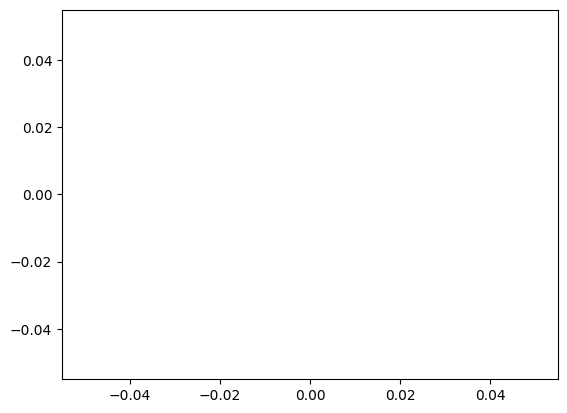

In [159]:
plt.plot([x.mean() for x in farm.history[1:]])